# Predicting Severe Injury Outcomes in Traffic Crashes

This project develops machine learning models to predict whether a crash results in severe injury (incapacitated or fatal) using information available prior to or at the time of a crash, including driver characteristics, roadway context, environment, vehicle type, restraint use, and speed involvement.

Because severe injuries are relatively rare, the task is formulated as an imbalanced binary classification problem. Multiple models are evaluated, and performance is assessed using metrics appropriate for rare-event prediction, including ROC AUC and Precision–Recall AUC.

The goal is for the model to answer: "Given a crash happened, how likely is the crash to result in a severe injury for the driver?” and select the best model for deployment.

## Data Overview

The dataset contains crash-level records with information on drivers, vehicles, environmental conditions, and safety features. The dataset is from the NHTSA Crash Report Sampling System (CRSS) covering car crushes in the U.S. from 2019–2023.

The outcome variable indicates whether a crash resulted in a severe injury.

In [1]:
import sys, sklearn, numpy, joblib
print("python:", sys.executable)
print("sklearn:", sklearn.__version__)
print("numpy:", numpy.__version__)
print("joblib:", joblib.__version__)

python: C:\Users\admins\anaconda3\envs\crash-app\python.exe
sklearn: 1.5.1
numpy: 1.26.4
joblib: 1.5.3


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
DATA_PATH = Path("..") / "data" / "processed" / "crss_modeling_severe.csv"
df = pd.read_csv(DATA_PATH, low_memory=False)
df.shape

(467529, 317)

In [3]:
df["TARGET_SEVERE"].value_counts(normalize=True)

TARGET_SEVERE
0    0.940491
1    0.059509
Name: proportion, dtype: float64

From the procesed dataset of U.S. car crashes: 
- 6% of the drivers in a car crush had severe injuries (incapacitated or fatal)
- 94% of the drivers in a car crush had non-severe injuries

Only about 6% of observations are labeled as severe, this is a highly imbalanced classification problem: 
- Accuracy alone will be misleading, since a model that always predicts “non-severe” would still achieve high accuracy
- Metrics like ROC AUC, PR AUC, recall, precision matter
- Class imbalance handling is needed

## Feature Selection and Leakage Prevention

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

The target variable is separated from the feature set to ensure that no outcome column is used during feature selection or preprocessing. In addition, features were manually selected to contain only variables plausibly known prior to or at the time of the crash to avoid post-impact proxies.

In [5]:
# target
df["TARGET_SEVERE"] = df["TARGET_SEVERE"].astype(int)
y = df["TARGET_SEVERE"].copy()

# features (start by dropping target)
X = df.drop(columns=["TARGET_SEVERE"]).copy()

print("X shape:", X.shape)
print("y mean:", y.mean())

X shape: (467529, 316)
y mean: 0.05950860802217616


To reduce dimensionality, key features are selected. These include driver characteristics, behavior, time, environment,
and vehicle safety attributes that should be available prior to or at the moment of a crash.

In [6]:
FEATURE_COLUMNS = [
    # PERSON & IMPAIRMENT
    "AGE_IM",
    "SEX_IM",
    "ALCOHOL",
    "DRUGS",
    "NUMOCCS",

    # TIME & ENVIRONMENT
    "HOUR_acc",
    "MONTH_acc",
    "DAY_WEEK",
    "LGTCON_IM",
    "WEATHR_IM",
    "REGION",

    # LOCATION & ROADWAY
    "REL_ROAD",
    "RELJCT2_IM",

    # VEHICLE (vehicle type)
    "BODY_TYP",

    # SAFETY BEHAVIOR (driver choice)
    "REST_USE",
    "SPEEDREL",
]

model_cols = [c for c in FEATURE_COLUMNS if c in X.columns]

print(f"Using {len(model_cols)} features:")
print(model_cols)

X_model = X[model_cols].copy()


Using 16 features:
['AGE_IM', 'SEX_IM', 'ALCOHOL', 'DRUGS', 'NUMOCCS', 'HOUR_acc', 'MONTH_acc', 'DAY_WEEK', 'LGTCON_IM', 'WEATHR_IM', 'REGION', 'REL_ROAD', 'RELJCT2_IM', 'BODY_TYP', 'REST_USE', 'SPEEDREL']


In [7]:
#explicit check to guard against accidental inclusion of post-crash or outcome-related variables.
leakage_terms = ["INJ", "SEV", "FATAL", "HOSP", "EMS"]
assert not any(any(k in c.upper() for k in leakage_terms) for c in X_model.columns)

sCRSS provides imputed versions (e.g., *_IM) that supply standardized codes when the original value is missing or unknown. These were used directly, so no additional statistical imputation was needed for the selected features.

## Train/test split (stratified)

The data is split into training (80%) and test (20%) sets using stratification to preserve the proportion of severe injuries in both sets. The stratification preserves the ~6% severe injury rate in both train and test sets.

In [8]:
from sklearn.model_selection import train_test_split

y_model = y.loc[X_model.index]

X_train, X_test, y_train, y_test = train_test_split(
    X_model,
    y_model,
    test_size=0.2,
    stratify=y_model,
    random_state=42
)

print("Train positive rate:", y_train.mean())
print("Test  positive rate:", y_test.mean())

Train positive rate: 0.05950970929595239
Test  positive rate: 0.059504202938848845


## Preprocessing (one-hot encode categoricals)

Some variables are numeric (e.g., age, hour), while others are coded categories (e.g., weather, restraint use).  
Numeric features are standardized, categorical features are one-hot encoded. 

Some variables in the CRSS dataset include imputed versions (e.g., *_IM) that provide standardized codes when original police-reported values are missing or unknown. These imputed fields are used directly, so no additional statistical imputation is applied during preprocessing.

All preprocessing steps are included inside a pipeline to prevent data leakage. 

In [9]:
numeric_cols = [
    "AGE_IM",
    "HOUR_acc",
    "MONTH_acc",
    "NUMOCCS",
]

categorical_cols = [
    "SEX_IM",
    "ALCOHOL",
    "DRUGS",
    "DAY_WEEK",
    "LGTCON_IM",
    "WEATHR_IM",
    "REGION",
    "REL_ROAD",
    "RELJCT2_IM",
    "BODY_TYP",
    "REST_USE",
    "SPEEDREL",
]

In [10]:
set(numeric_cols + categorical_cols) == set(X_model.columns) #checking if all columns are selected

True

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_pipe = Pipeline(steps=[
    ("scaler", StandardScaler())  # good for logistic; harmless for many models if used separately
])

categorical_pipe = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("cat", categorical_pipe, categorical_cols),
    ],
    remainder="drop"
)

In [12]:
Xt = preprocess.fit_transform(X_train)
print("Transformed train shape:", Xt.shape)

Transformed train shape: (374023, 152)


## Testing Three Models

### Logistic Model

We begin with a logistic regression model as a strong, interpretable baseline:
- Outputs calibrated probabilities of severe injury
- Uses class-weight balancing to account for class imbalance
- Works well with high-dimensional one-hot encoded data
- Easy to interpret and compare against more complex models later

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [14]:
logit = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(
            max_iter=2000,
            class_weight="balanced"
        ))
    ]
)

In [15]:
logit.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE_IM', 'HOUR_acc',
                                                   'MONTH_acc', 'NUMOCCS']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['SEX_IM', 'ALCOHOL', 'DRUGS',
                                                   'DAY_WEEK', 'LGTCON_IM',
                                                   'WEATHR_IM', 'REGION',
                                                   'REL_ROAD', 'RELJCT2_IM',
                                                   'BODY_TYP', 'REST_USE',
                                                   'SPEEDREL'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

### Logistic Model Evaluation

Because severe injury is rare, multiple evaluation metrics are used:

### ROC AUC
Measures how well the model ranks higher-risk cases above lower-risk ones, independent of any decision threshold.

### Precision–Recall (PR) AUC
More informative for imbalanced data.  
The baseline PR AUC equals the prevalence of severe injury (~6%).  
Any model performing substantially above this baseline provides useful signal.

### Classification Thresholds
Predicted probabilities can be converted into class labels using different thresholds depending on the use case:
- Lower threshold → higher recall (fewer missed severe injuries)
- Higher threshold → higher precision (fewer false alarms)


In [16]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

y_proba = logit.predict_proba(X_test)[:, 1]
y_hat = (y_proba >= 0.5).astype(int)

roc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)  # PR AUC (Average Precision)
acc = accuracy_score(y_test, y_hat)

roc, pr_auc, acc

(0.8228202762012562, 0.32617711807488853, 0.8217975317091951)

**The logistic regression model achieves:**

- ROC AUC ≈ 0.82, indicating strong ability to rank high-risk crashes above low-risk ones.
- PR AUC ≈ 0.33, which is substantially higher than the baseline severe-injury rate (~0.06), showing meaningful predictive signal despite class imbalance.
- Accuracy ≈ 0.82, though accuracy is less informative here due to the rarity of severe injuries.

Overall, the model performs well at ranking risk and provides useful discrimination beyond chance, even under strong class imbalance.

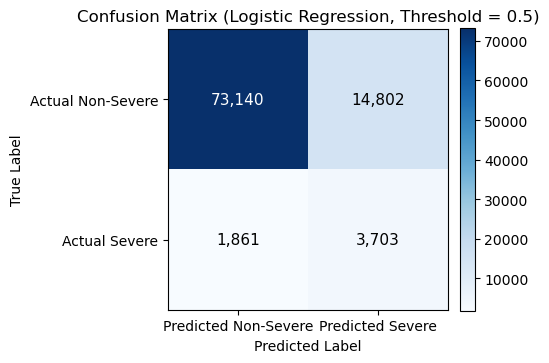

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_hat)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, cmap="Blues")

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]:,}",
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black",
                fontsize=11)

# Axis labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Predicted Non-Severe", "Predicted Severe"])
ax.set_yticklabels(["Actual Non-Severe", "Actual Severe"])

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix (Logistic Regression, Threshold = 0.5)")

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

**Confusion Matrix**

At threshold of 0.5, 
- True Negatives (73,140): correctly predicted non-severe
- False Positives (14,802): predicted severe but actually not
- False Negatives (1,861): severe injuries missed
- True Positives (3,703): severe injuries correctly identified

The model correctly identifies a majority of severe cases but produces a substantial number of false positives.

In [18]:
from sklearn.metrics import classification_report

print("Positive rate:", y_test.mean())
print(classification_report(y_test, y_hat, digits=3))

Positive rate: 0.059504202938848845
              precision    recall  f1-score   support

           0      0.975     0.832     0.898     87942
           1      0.200     0.666     0.308      5564

    accuracy                          0.822     93506
   macro avg      0.588     0.749     0.603     93506
weighted avg      0.929     0.822     0.863     93506



At the default 0.5 threshold, the logistic regression model identifies about two-thirds of severe injury cases (recall ≈ 0.66), indicating reasonable sensitivity to high-risk crashes. This makes the model suitable for settings where missing severe outcomes is costly.

Precision is relatively low (~20%), meaning many predicted severe cases are false positives. This behavior is expected in highly imbalanced settings where severe outcomes are rare, and reflects a tradeoff favoring recall over precision.

Although overall accuracy appears high (≈82%), accuracy is not a reliable metric here because a model that always predicts “non-severe” would also achieve high accuracy. Therefore, evaluation focuses on recall, precision, and PR-AUC, which better reflect performance on rare but critical outcomes.


## Precision–Recall Curve

The Precision–Recall curve shows the tradeoff between:
- **Recall**: how many severe injuries are correctly identified
- **Precision**: how many predicted severe injuries are actually severe

The dashed horizontal line represents the baseline (random guessing).
Curves above this line indicate meaningful predictive power.

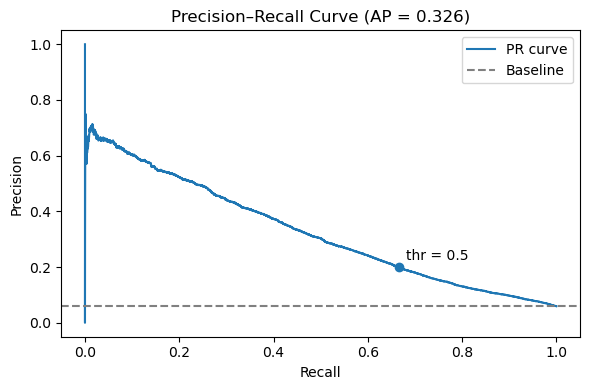

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, thr = precision_recall_curve(y_test, y_proba)

# align threshold array (thr is length = len(prec) - 1)
th = np.r_[thr, 1.0]
idx = np.argmin(np.abs(th - 0.5))

ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 4))

# PR curve
plt.plot(rec, prec, label="PR curve")

# baseline
plt.axhline(y=y_test.mean(), linestyle="--", color="gray", label="Baseline")

# mark threshold = 0.5
plt.scatter(rec[idx], prec[idx], zorder=3)
plt.annotate(
    "thr = 0.5",
    (rec[idx], prec[idx]),
    textcoords="offset points",
    xytext=(5, 5)
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})")
plt.legend()
plt.tight_layout()
plt.show()

### Threshold Selection and Decision Policy

Model outputs are probabilities rather than class labels. A default threshold of 0.5 is commonly used but may not appropriate for rare outcomes such as severe injury.

Lowering the classification threshold increases recall (identifying more severe cases) at the cost of lower precision. Conversely, higher thresholds reduce false positives but may miss severe cases. 

To illustrate this tradeoff, we evaluate performance across thresholds using the precision–recall curve and report the threshold that maximizes the F1 score as one possible operating point. This threshold balances precision and recall but does not represent a universally optimal choice.

In practice, threshold selection depends on policy objectives, such as prioritizing safety (higher recall) or minimizing false alarms (higher precision).

In [20]:
f1 = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = np.argmax(f1)
best_thr = thr[best_idx-1]  # thr is shorter by 1
best_thr, prec[best_idx], rec[best_idx], f1[best_idx]

(0.8006494320395551,
 0.3692007162624125,
 0.4076204169662114,
 0.3874604937212062)

In [21]:
thresholds = {
    "Default (0.5)": 0.5,
    "F1-optimal": best_thr
}

for name, t in thresholds.items():
    preds = (y_proba >= t).astype(int)
    print("\n", name)
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds, digits=3))


 Default (0.5)
[[73140 14802]
 [ 1861  3703]]
              precision    recall  f1-score   support

           0      0.975     0.832     0.898     87942
           1      0.200     0.666     0.308      5564

    accuracy                          0.822     93506
   macro avg      0.588     0.749     0.603     93506
weighted avg      0.929     0.822     0.863     93506


 F1-optimal
[[84066  3876]
 [ 3296  2268]]
              precision    recall  f1-score   support

           0      0.962     0.956     0.959     87942
           1      0.369     0.408     0.387      5564

    accuracy                          0.923     93506
   macro avg      0.666     0.682     0.673     93506
weighted avg      0.927     0.923     0.925     93506



### Interpretation of Results

At the default threshold (0.5):
- The model identifies most severe injuries (high recall)
- Precision is low due to class imbalance; this leads to many false positives, which is expected in highly imbalanced classification problems

At the F1-optimized threshold:
- Precision improves substantially
- Recall decreases moderately
- Improves overall balance between between false positives and false negatives

**Threshold selection is a choice.**

## Random Forest Model

Random Forest is a non-linear ensemble model that builds many decision trees on bootstrapped samples
and aggregates their predictions. Unlike logistic regression, it can automatically capture feature
interactions and non-linear effects.

Class weighting is used to account for the imbalance between severe and non-severe injury cases.


In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_leaf=10,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ))
])

rf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE_IM', 'HOUR_acc',
                                                   'MONTH_acc', 'NUMOCCS']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['SEX_IM', 'ALCOHOL', 'DRUGS',
                                                   'DAY_WEEK', 'LGTCON_IM',
                                                   'WEATHR_IM', 'REGION',
                                                   'REL_ROAD', 'RELJCT2_IM',
                                                   'BODY_TYP', 'REST_USE',
                                                   'SPEEDREL'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        min_samples_leaf=10, n_jobs=-1,
                                        random_state=42))])

In [23]:
y_proba_rf = rf.predict_proba(X_test)[:, 1]
y_hat_rf = (y_proba_rf >= 0.5).astype(int)

rf_roc = roc_auc_score(y_test, y_proba_rf)
rf_pr  = average_precision_score(y_test, y_proba_rf)
rf_acc = accuracy_score(y_test, y_hat_rf)

rf_roc, rf_pr, rf_acc


(0.8258412989699881, 0.3403068793686874, 0.867259854982568)

- **ROC AUC ≈ 0.82**, indicating strong ranking ability between severe and non-severe crashes  
- **PR AUC ≈ 0.34**, substantially higher than the baseline prevalence (~6%)  
- **Accuracy ≈ 0.87**, though accuracy is less informative due to class imbalance  

The Random Forest model captures nonlinear relationships and interactions among features such as vehicle type, restraint use, speed-related indicators, and environmental conditions. This flexibility leads to improved discrimination compared with logistic regression, at the cost of reduced interpretability.

## Gradient Boosting Model

Gradient Boosting builds trees sequentially, where each new tree focuses on correcting errors made
by the previous ones. This often leads to stronger predictive performance compared to bagging-based
methods like Random Forest.


In [24]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_pipe_ordinal = Pipeline(steps=[
    ("ordinal", OrdinalEncoder(
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ))
])

preprocess_gb = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("cat", categorical_pipe_ordinal, categorical_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


In [25]:
# HistGradientBoosting with dense conversion
from sklearn.ensemble import HistGradientBoostingClassifier

gb = Pipeline([
    ("preprocess_gb", preprocess_gb),  # Your original
    ("model", HistGradientBoostingClassifier(
        max_iter=200,
        learning_rate=0.1,
        max_depth=5,
        early_stopping=True,
        validation_fraction = 0.1,
        random_state=42
    ))
])

In [26]:
gb.fit(X_train, y_train)

Pipeline(steps=[('preprocess_gb',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE_IM', 'HOUR_acc',
                                                   'MONTH_acc', 'NUMOCCS']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['SEX_IM', 'ALCOHOL', 'DRUGS',
                                                   'DAY_WEEK', 'LGTCON_IM',
                                                   'WEATHR_IM', 'REGION',
                                                   'REL_ROAD', 'RELJCT2_IM',
                                                   'BODY_TYP', 'REST_USE',
                                                   'SPEEDREL'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 HistGradientBoostingClassifier(early_stopping=True,
                                                max_depth=5, max_iter=200,
                                                random_state=42))])

In [27]:
y_proba_gb = gb.predict_proba(X_test)[:, 1]
y_hat_gb = (y_proba_gb >= 0.5).astype(int)

gb_roc = roc_auc_score(y_test, y_proba_gb)
gb_pr  = average_precision_score(y_test, y_proba_gb)
gb_acc = accuracy_score(y_test, y_hat_gb)

gb_roc, gb_pr, gb_acc

(0.8282114062384198, 0.3490962643781774, 0.9438110923363207)

### Gradient Boosting Performance

Gradient Boosting achieves the strongest overall performance among the tested models.

- **ROC AUC ≈ 0.83**, indicating strong ability to rank high-risk crashes above low-risk ones  
- **PR AUC ≈ 0.35**, substantially higher than the baseline severe-injury rate (~6%)  
- **Accuracy ≈ 0.94**, though accuracy is less informative due to class imbalance  

Compared to logistic regression and random forest, gradient boosting provides the best precision–recall performance, suggesting it captures nonlinear interactions that improve identification of severe injury cases.


In [28]:
#Load the gradient boosting model into joblib

from pathlib import Path
import joblib

NOTEBOOK_DIR = Path().resolve()
ROOT = NOTEBOOK_DIR.parent

MODEL_DIR = ROOT / "src" / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(gb, MODEL_DIR / "severe_injury_model.joblib")

['C:\\Users\\admins\\OneDrive\\Desktop\\Github Projects\\us-car-crash\\src\\models\\severe_injury_model.joblib']

## Model Comparison and Selection

We compare three models: Logistic Regression, Random Forest, and Gradient Boosting.
Performance is evaluated using ROC AUC, PR AUC, and accuracy.

In [29]:
results = pd.DataFrame({
    "Model": ["Logistic", "Random Forest", "Gradient Boosting"],
    "ROC AUC": [roc, rf_roc, gb_roc],
    "PR AUC": [pr_auc, rf_pr, gb_pr],
    "Accuracy": [acc, rf_acc, gb_acc]
})

results

,Model,ROC AUC,PR AUC,Accuracy
0,Logistic,0.822820,0.326177,0.821798
1,Random Forest,0.825841,0.340307,0.867260
2,Gradient Boosting,0.828211,0.349096,0.943811


Gradient Boosting achieves the highest PR AUC, meaning it performs best at identifying severe injury cases under strong class imbalance. 

Logistic regression performs the worst, but offers interpretability and simplicity. Random Forest provides improvement over logistic regression. 

**Overall, Gradient Boosting offers the best predictive performance, while logistic regression remains a strong and interpretable baseline.**


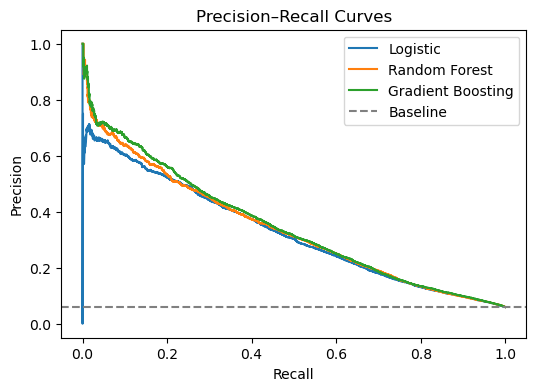

In [30]:
plt.figure(figsize=(6,4))

prec_l, rec_l, _ = precision_recall_curve(y_test, y_proba)
prec_r, rec_r, _ = precision_recall_curve(y_test, y_proba_rf)
prec_g, rec_g, _ = precision_recall_curve(y_test, y_proba_gb)

plt.plot(rec_l, prec_l, label="Logistic")
plt.plot(rec_r, prec_r, label="Random Forest")
plt.plot(rec_g, prec_g, label="Gradient Boosting")

plt.axhline(y=y_test.mean(), linestyle="--", color="gray", label="Baseline")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.show()

The precision–recall curves show that all three models perform substantially better than random guessing (dashed baseline). 

Gradient Boosting consistently achieves the highest precision across most recall levels, indicating better identification of severe injury cases. Random Forest performs slightly better than logistic regression, while logistic regression remains a strong and interpretable baseline.

As recall increases, precision decreases for all models, reflecting the trade-off between identifying more severe cases and introducing more false positives.


## Feature Interpretation

### Logistic Coefficients

In [31]:
feature_names = logit.named_steps["preprocess"].get_feature_names_out()
coefs = logit.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs
}).sort_values("coef", key=abs, ascending=False)

coef_df

,feature,coef
115,cat__BODY_TYP_78.0,-1.687058
100,cat__BODY_TYP_52.0,-1.603734
142,cat__REST_USE_20,1.585941
98,cat__BODY_TYP_50.0,-1.529997
120,cat__BODY_TYP_83.0,1.508163
...,...,...
59,cat__RELJCT2_IM_5,0.008658
24,cat__LGTCON_IM_5,-0.008301
8,cat__ALCOHOL_9,0.006847
95,cat__BODY_TYP_45.0,-0.001329


Logistic regression coefficients represent changes in the *log-odds* of severe injury, holding all other variables constant. Positive coefficients indicate higher predicted risk, while negative coefficients indicate lower risk.

The logistic regression results suggest that crash characteristics related to restraint use and vehicle type play the biggest role in predicting severe injury. Because categorical variables are one-hot encoded, each coefficient represents the effect of a specific category relative to a reference category. As a result, coefficient magnitudes should be interpreted comparatively rather than as absolute effects.

### Random Forest Feature Importance

In [32]:
rf_importances = rf.named_steps["model"].feature_importances_

rf_imp_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": rf_importances
    })
    .sort_values("importance", ascending=False)
)

rf_imp_df.head(15)

,feature,importance
142,cat__REST_USE_20,0.204735
139,cat__REST_USE_3,0.090624
42,cat__REL_ROAD_1,0.077702
45,cat__REL_ROAD_4,0.077251
117,cat__BODY_TYP_80.0,0.048595
3,num__NUMOCCS,0.042907
57,cat__RELJCT2_IM_3,0.039141
6,cat__ALCOHOL_1,0.038715
0,num__AGE_IM,0.036410
1,num__HOUR_acc,0.033760


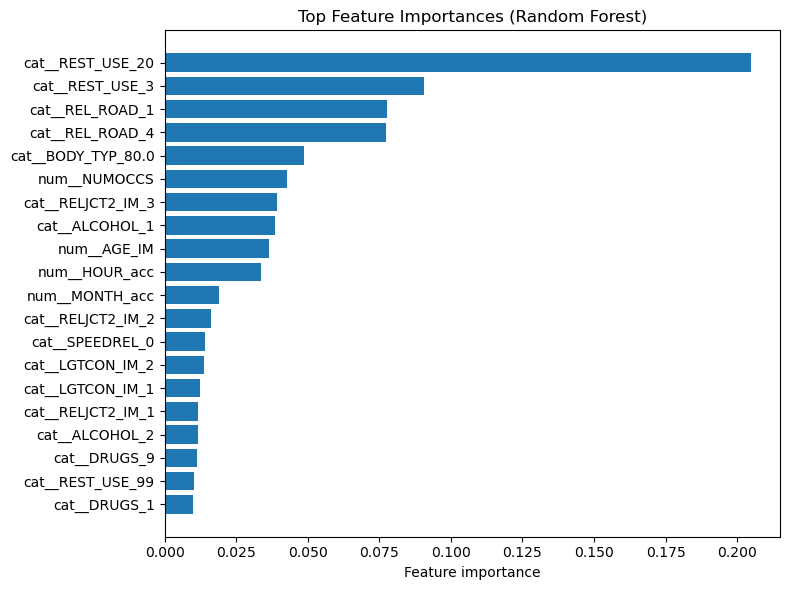

In [33]:
top_rf = rf_imp_df.head(20)

plt.figure(figsize=(8, 6))
plt.barh(top_rf["feature"][::-1], top_rf["importance"][::-1])
plt.xlabel("Feature importance")
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

The Random Forest model highlights features related to restraint use, roadway context, and vehicle characteristics as having the highest importance. These importance scores reflect how frequently and effectively features are used to reduce impurity across trees, rather than direct causal effects. Features with many categorical levels or strong interactions may receive higher importance scores.

### Gradient Boosting Feature Importance

In [34]:
import pandas as pd
from sklearn.inspection import permutation_importance

# If binary classification:
scoring = "roc_auc"   # or "average_precision", "accuracy"

r = permutation_importance(
    gb, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring=scoring
)

feature_names = gb.named_steps["preprocess_gb"].get_feature_names_out()

gb_imp_df = (pd.DataFrame({
    "feature": feature_names,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
})
.sort_values("importance_mean", ascending=False))

gb_imp_df.head(15)

,feature,importance_mean,importance_std
14,REST_USE,0.095017,0.001631
11,REL_ROAD,0.035666,0.000944
12,RELJCT2_IM,0.034298,0.001858
4,SEX_IM,0.023293,0.001020
13,BODY_TYP,0.019472,0.001159
2,MONTH_acc,0.011654,0.000451
3,NUMOCCS,0.009899,0.000496
0,AGE_IM,0.009034,0.001053
15,SPEEDREL,0.004721,0.000344
5,ALCOHOL,0.003610,0.000376


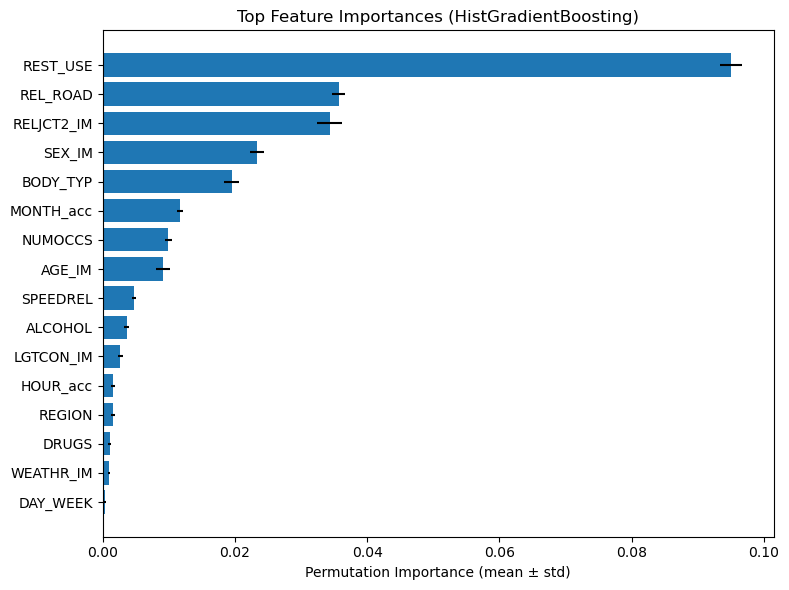

In [35]:
plt.figure(figsize=(8, 6))
plt.barh(
    gb_imp_df["feature"][::-1],
    gb_imp_df["importance_mean"][::-1],
    xerr=gb_imp_df["importance_std"][::-1]
)
plt.xlabel("Permutation Importance (mean ± std)")
plt.title("Top Feature Importances (HistGradientBoosting)")
plt.tight_layout()
plt.show()

The permutation importance results indicate that variables related to restraint use, roadway context, and vehicle characteristics contribute most strongly to the model’s predictive performance.

### Interpreting Feature Importance


Across models, variables related to restraint use and roadway context consistently rank among the most important predictors of severe injury. Vehicle type also appears frequently among top features, indicating that structural differences across vehicles matter. Age and alcohol-related variables contribute moderately, while time-based variables (hour, month) have relatively smaller influence once other factors are controlled for.

## Limitations

Several limitations should be noted. First, this analysis is observational and does not establish causal relationships. Feature importance reflects predictive associations rather than causal effects.

Second, the dataset is highly imbalanced, which complicates evaluation and may reduce precision at higher recall levels. While threshold tuning helps address this issue, optimal operating points depend on deployment goals.

Third, several variables are encoded or imputed within the CRSS dataset. Although these imputations enable complete-case modeling, they may introduce noise or measurement error.

Finally, more advanced interpretability approaches (e.g., SHAP values or partial dependence analysis) could provide additional insight into feature effects at the individual prediction level.



## Conclusion

This project shows that machine learning models can effectively predict severe injury outcomes using U.S. car crash report data. Among the models evaluated, Gradient Boosting delivers the strongest overall performance, particularly in terms of precision–recall tradeoffs, while logistic regression provides a strong and interpretable baseline.

Across all models, variables related to restraint use, road context, and vehicle characteristics consistently emerge as the most influential predictors. Age and time factors contribute additional but comparatively smaller effects.

Overall, the modeling approach is reproducible and well suited for applications such as post-crash analysis or policy-oriented safety studies.